In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
from copy import deepcopy
from types import SimpleNamespace

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc

from run import utils

Auto-Sklearn cannot be imported.


In [3]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
# init config
config = SimpleNamespace()
config.prob = "tsp"
config.nodes = 20
config.feat = 10
config.net = []
config.optm = "adam"
config.batch = 32
config.l1 = 0.0
config.l2 = 0.0
config.lan = "gurobi"
config.proc = 1
config.path = "./res"
config.sftp = False

In [5]:
# polynomial degree
degs = [1, 2, 4, 6]

In [6]:
def getPath(config, mthd):
    config = deepcopy(config)
    if mthd == "spo":
        config.mthd = "spo"
        config.lr = 1e-2
        config.form = "dfj"
        config.rel = False
    if mthd == "spo rel(gg)":
        config.mthd = "spo"
        config.lr = 1e-2
        config.form = "gg"
        config.rel = True
    if mthd == "spo rel(mtz)":
        config.mthd = "spo"
        config.lr = 1e-2
        config.form = "mtz"
        config.rel = True
    if mthd == "dbb":
        config.mthd = "dbb"
        config.loss = "r"
        config.lr = 1e-1
        config.form = "dfj"
        config.smth = 20
        config.rel = False
    if mthd == "dbb rel(gg)":
        config.mthd = "dbb"
        config.loss = "r"
        config.lr = 1e-1
        config.form = "gg"
        config.smth = 20
        config.rel = True
    if mthd == "dbb rel(mtz)":
        config.mthd = "dbb"
        config.loss = "r"
        config.lr = 1e-1
        config.form = "mtz"
        config.smth = 20
        config.rel = True
    if mthd == "pfyl":
        config.mthd = "pfyl"
        config.loss = "r"
        config.lr = 1e-2
        config.form = "dfj"
        config.samp = 1
        config.sig = 1.0
        config.rel = False
    if mthd == "pfyl rel(gg)":
        config.mthd = "pfyl"
        config.loss = "r"
        config.lr = 1e-2
        config.form = "gg"
        config.samp = 1
        config.sig = 1.0
        config.rel = True
    if mthd == "pfyl rel(mtz)":
        config.mthd = "pfyl"
        config.loss = "r"
        config.lr = 1e-2
        config.form = "mtz"
        config.samp = 1
        config.sig = 1.0
        config.rel = True
    path = utils.getSavePath(config)
    return path

In [7]:
def getDf(config, degs, mthd, col="Unamb SPO"):
    dfs = pd.DataFrame()
    for deg in degs:
        config.deg = deg
        df = pd.read_csv(getPath(config, mthd))
        dfs[deg] = df[col]
    return dfs

In [8]:
def getElapsed(config):
    df = pd.DataFrame(columns=["Method", "Data Size", "Noise", "Elapsed_mean", "Elapsed_std"])
    methods = ["spo", "spo rel(gg)", "spo rel(mtz)",
               "pfyl", "pfyl rel(gg)", "pfyl rel(mtz)",
               "dbb", "dbb rel(gg)", "dbb rel(mtz)"]
    for mthd in methods:
        elapses = np.empty((1,0))
        for noise in [0.0, 0.5]:
            config = deepcopy(config)
            config.noise = noise
            for data in [100, 1000, 5000]:
                # get df
                config.data = data
                cur_df = getDf(config, degs, mthd, "Elapsed")
                # per iter
                if data == 100:
                    cur_df = getDf(config, degs, mthd, "Elapsed").to_numpy() / 200 / np.ceil(data / config.batch)
                if data == 1000:
                    cur_df = getDf(config, degs, mthd, "Elapsed").to_numpy() / 20 / np.ceil(data / config.batch)
                if data == 5000:
                    cur_df = getDf(config, degs, mthd, "Elapsed").to_numpy() / 4 / np.ceil(data / config.batch)
                    elapses = np.concatenate((elapses, cur_df.reshape(1,-1)), axis=1)
        # stat
        elapsed_mean = elapses.mean()
        elapsed_std = elapses.std()
        row = {"Method":mthd, "Data Size":data, "Noise":noise, "Elapsed_mean":elapsed_mean, "Elapsed_std":elapsed_std}
        df = df.append(row, ignore_index=True)
    # list
    means, stds = [], []
    for mthd in methods:
        means.append(df[df["Method"]==mthd]["Elapsed_mean"].values[0])
        stds.append(df[df["Method"]==mthd]["Elapsed_std"].values[0])
    return means, stds

In [9]:
def lighten(color, amount=0.9):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [10]:
def drawBarPlot(config):
    val, err = getElapsed(config)
    # color map
    cmap = tc.tol_cmap("rainbow_discrete")(np.linspace(0, 1, 22))
    colors = [cmap[16], cmap[15], cmap[14], cmap[5], cmap[4], cmap[3],
              cmap[7], cmap[8], cmap[9], cmap[10], cmap[11], cmap[12]]
    for i in range(len(colors)):
        colors[i] = lighten(colors[i])
    # draw boxplot
    fig = plt.figure(figsize=(16,6))
    x = np.array(range(9))
    bar = plt.bar(x, height=val, width=0.6, edgecolor="w",
                   linewidth=3, color=colors, label="Training Set Size = 1000")
    plt.errorbar(x, val, yerr=err, capsize=5, capthick=2, linestyle="", marker="o",
                 markersize=3, color="k", elinewidth=2, alpha=0.7)
    # grid
    plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # labels and ticks
    plt.xlim(-0.5, 8.5)
    plt.ylim(0.0, 1.6)
    plt.xticks(ticks=x, fontsize=22,
               labels=["SPO+\n(DFJ)", "SPO+ Rel\n(GG)", "SPO+ Rel\n(MTZ)",
                       "PFYL\n(DFJ)", "PFYL Rel\n(GG)", "PFYL Rel\n(MTZ)",
                       "DBB\n(DFJ)", "DBB Rel\n(GG)", "DBB Rel\n(MTZ)"])
    plt.xlabel("Method", fontsize=36)
    plt.ylabel("Runtime per Iter (Sec)", fontsize=36)
    plt.yticks(fontsize=24)
    plt.title("TSP", fontsize=30)
    # save
    plt.show()
    fig.savefig("./images/rel-tsp-time.pdf", dpi=300)

In [11]:
def drawPlot(config, data, noise):
    # set config
    config = deepcopy(config)
    config.data = data
    config.noise = noise
    # get df
    df_spo_dfj  = getDf(config, degs, "spo")
    df_spo_gg  = getDf(config, degs, "spo rel(gg)")
    df_spo_mtz = getDf(config, degs, "spo rel(mtz)")
    df_pfyl_dfj  = getDf(config, degs, "pfyl")
    df_pfyl_gg  = getDf(config, degs, "pfyl rel(gg)")
    df_pfyl_mtz = getDf(config, degs, "pfyl rel(mtz)")
    df_dbb_dfj  = getDf(config, degs, "dbb")
    df_dbb_gg  = getDf(config, degs, "dbb rel(gg)")
    df_dbb_mtz = getDf(config, degs, "dbb rel(mtz)")
    # color map
    cmap = tc.tol_cmap("rainbow_discrete")(np.linspace(0, 1, 22))
    colors = [cmap[16], cmap[15], cmap[14], cmap[5], cmap[4], cmap[3],
              cmap[7], cmap[8], cmap[9], cmap[10], cmap[11], cmap[12]]
    for i in range(len(colors)):
        colors[i] = lighten(colors[i])
    # draw boxplot
    fig = plt.figure(figsize=(16,6))
    #######################################################################################################################
    c = colors[0]
    bp1 = plt.boxplot(df_spo_dfj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo_dfj.shape[1])-0.44, widths=0.08)
    c = colors[1]
    bp2 = plt.boxplot(df_spo_gg, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo_dfj.shape[1])-0.33, widths=0.08)
    c = colors[2]
    bp3 = plt.boxplot(df_spo_mtz, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo_dfj.shape[1])-0.22, widths=0.08)
    #######################################################################################################################
    c = colors[3]
    bp4 = plt.boxplot(df_pfyl_dfj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb_dfj.shape[1])-0.11, widths=0.08)
    c = colors[4]
    bp5 = plt.boxplot(df_pfyl_gg, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb_dfj.shape[1]), widths=0.08)
    c = colors[5]
    bp6 = plt.boxplot(df_pfyl_mtz, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb_dfj.shape[1])+0.11, widths=0.08)
    #######################################################################################################################
    c = colors[6]
    bp7 = plt.boxplot(df_dbb_dfj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb_dfj.shape[1])+0.22, widths=0.08)
    c = colors[7]
    bp8= plt.boxplot(df_dbb_gg, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb_dfj.shape[1])+0.33, widths=0.08)
    c = colors[8]
    bp9= plt.boxplot(df_dbb_mtz, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb_dfj.shape[1])+0.44, widths=0.08)    
    # vertical line
    plt.axvline(x=0.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.axvline(x=1.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    plt.axvline(x=2.5, color="k", linestyle="--", linewidth=1, alpha=0.75)
    # grid
    plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # labels and ticks
    plt.xlabel("Polynomial Degree", fontsize=36)
    plt.xticks(ticks=[0,1,2,3], labels=[1,2,4,6], fontsize=28)
    plt.ylabel("Normalized Regret", fontsize=36)
    plt.yticks(fontsize=24)
    plt.xlim(-0.5, 3.5)
    plt.ylim(-0.01, 0.44)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.title("Training Set Size = {},\nNoise Half−width = {}".format(config.data, config.noise), fontsize=30)
    plt.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0],
                bp5["boxes"][0], bp6["boxes"][0], bp7["boxes"][0], bp8["boxes"][0], bp9["boxes"][0]],
               ["SPO+ (DFJ)", "SPO+ Rel(GG)", "SPO+ Rel(MTZ)", "PFYL (DFJ)", "PFYL Rel(GG)",
                "PFYL Rel(MTZ)", "DBB (DFJ)", "DBB Rel(GG)", "DBB Rel(MTZ)"],
               fontsize=22, loc=2, labelspacing=0.2, handlelength=1, ncol=3)
    # save
    plt.show()
    fig.savefig("./images/rel-tsp-n{}e{}.pdf".format(data,int(10*noise)), dpi=300)

## Elapsed Time 

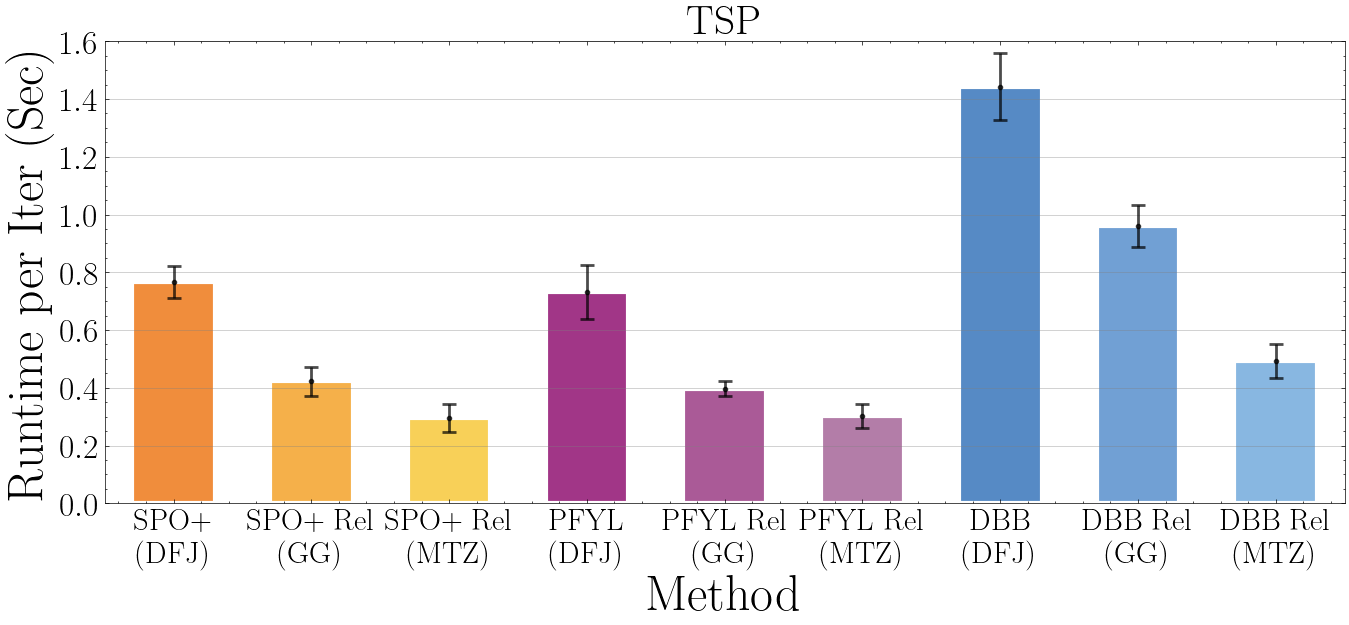

In [12]:
drawBarPlot(config)

## n = 100, e = 0

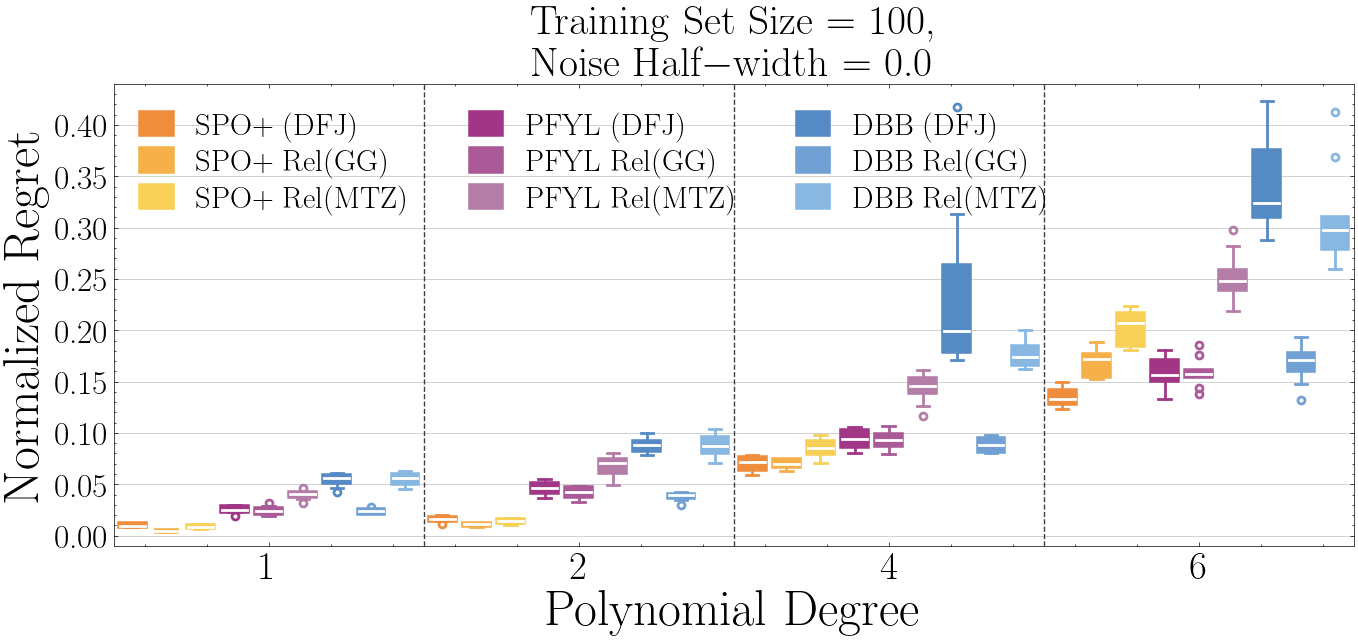

In [13]:
drawPlot(config, data=100, noise=0.0)

## n = 100, e = 0

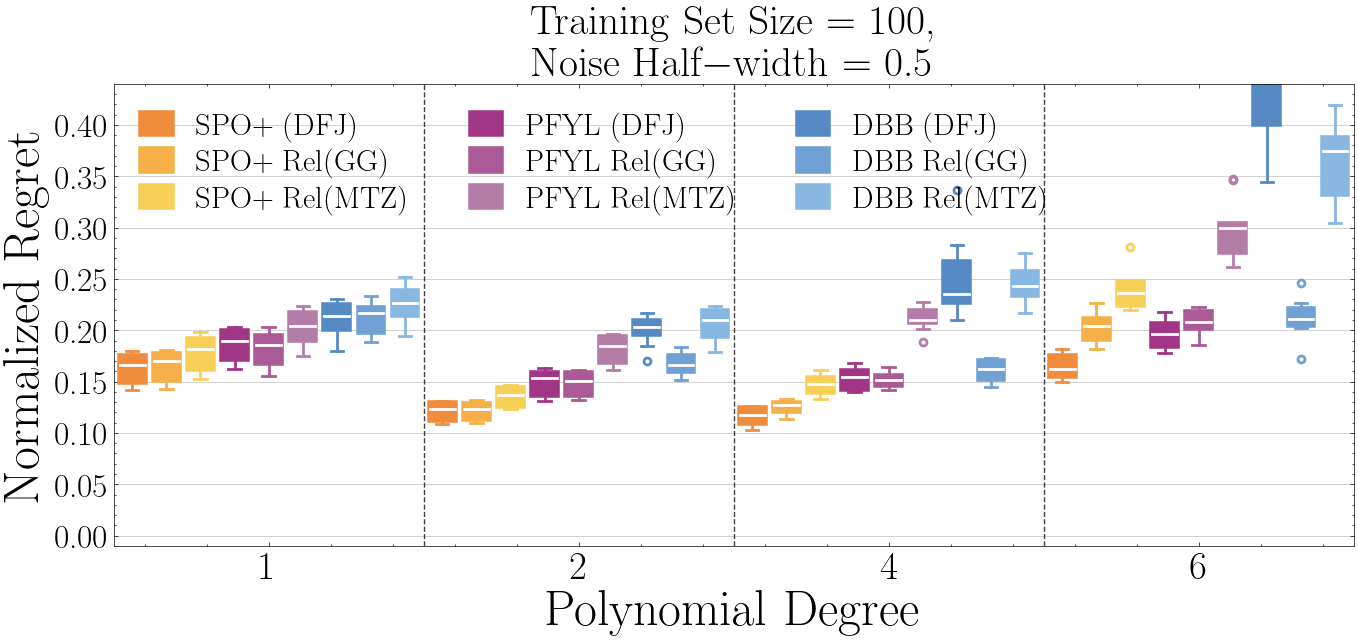

In [14]:
drawPlot(config, data=100, noise=0.5)

## n = 1000, e = 0

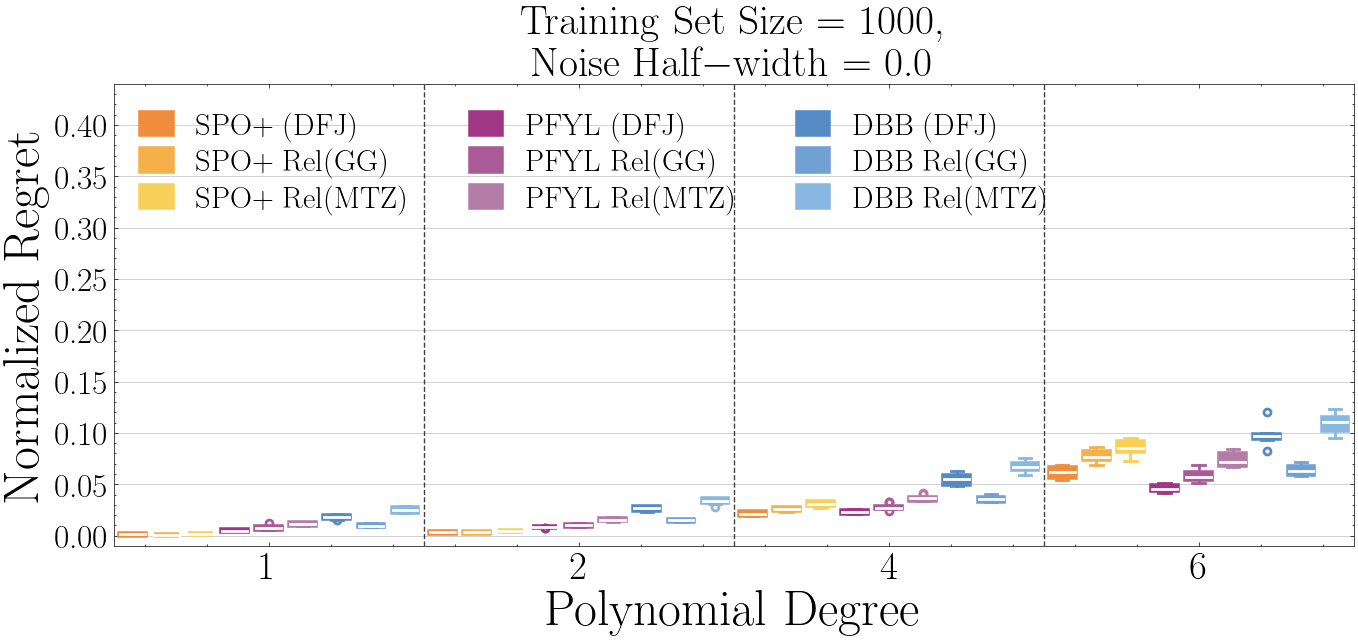

In [15]:
drawPlot(config, data=1000, noise=0.0)

## n = 1000, e = 0.5 

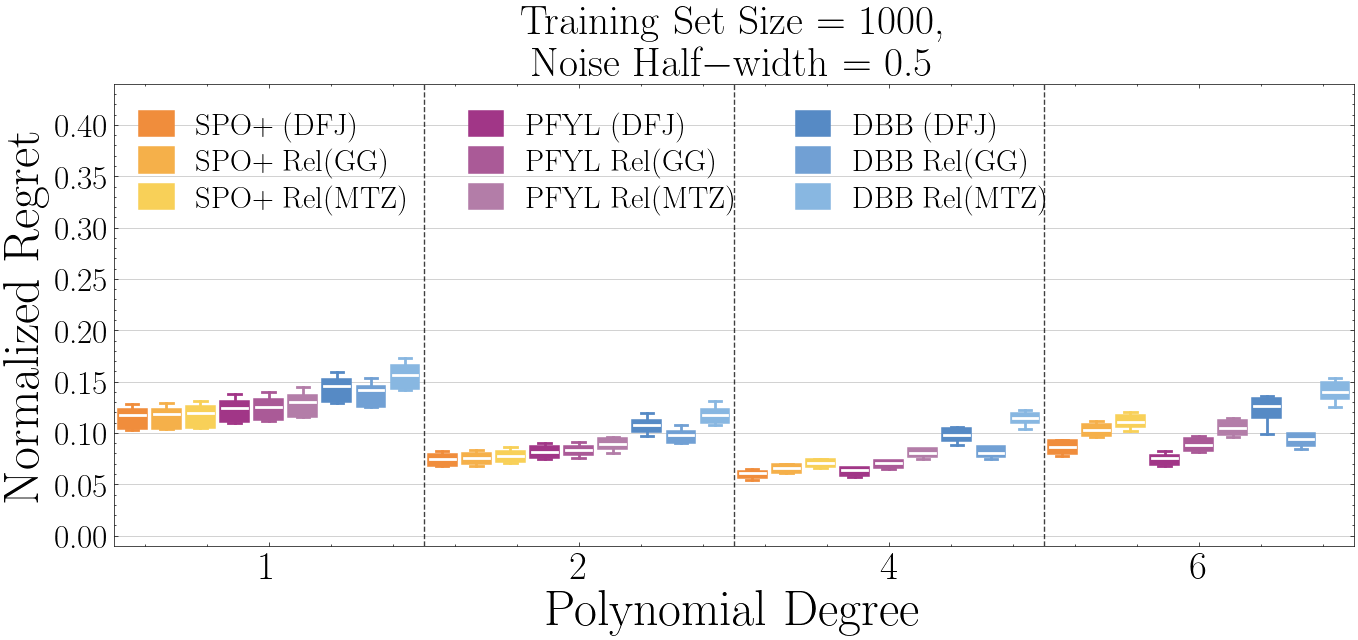

In [16]:
drawPlot(config, data=1000, noise=0.5)

## n = 5000, e = 0.0

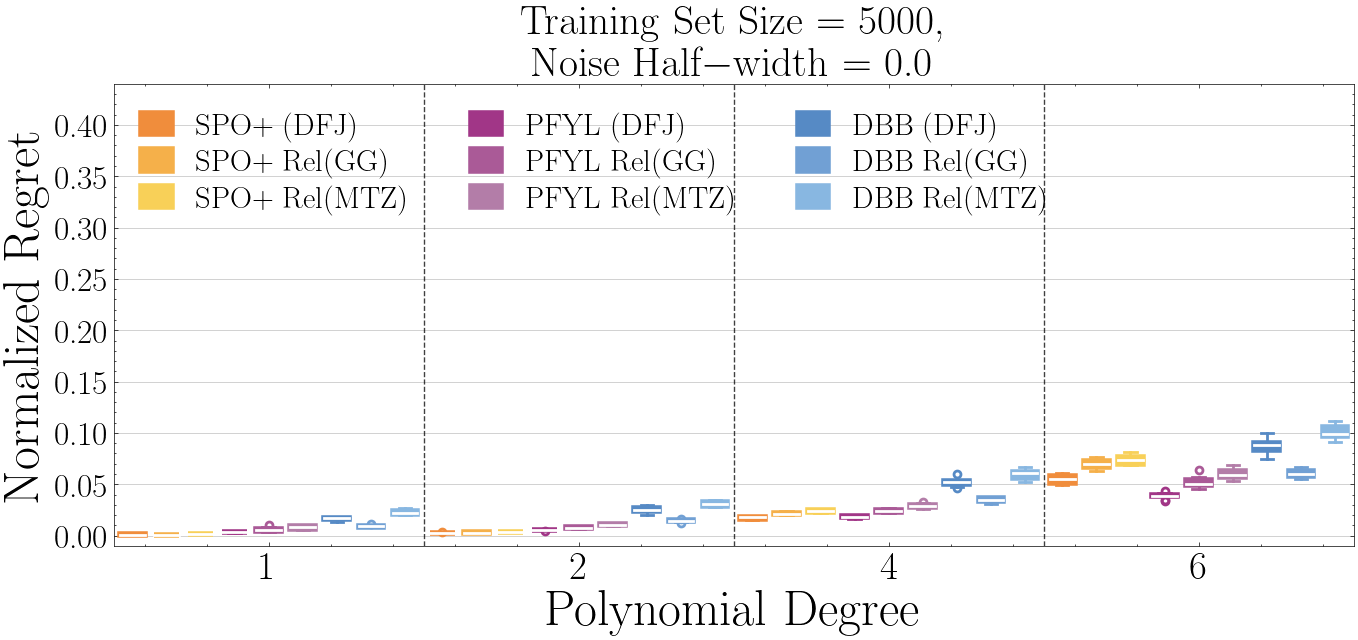

In [17]:
drawPlot(config, data=5000, noise=0.0)

## n = 5000, e = 0.5 

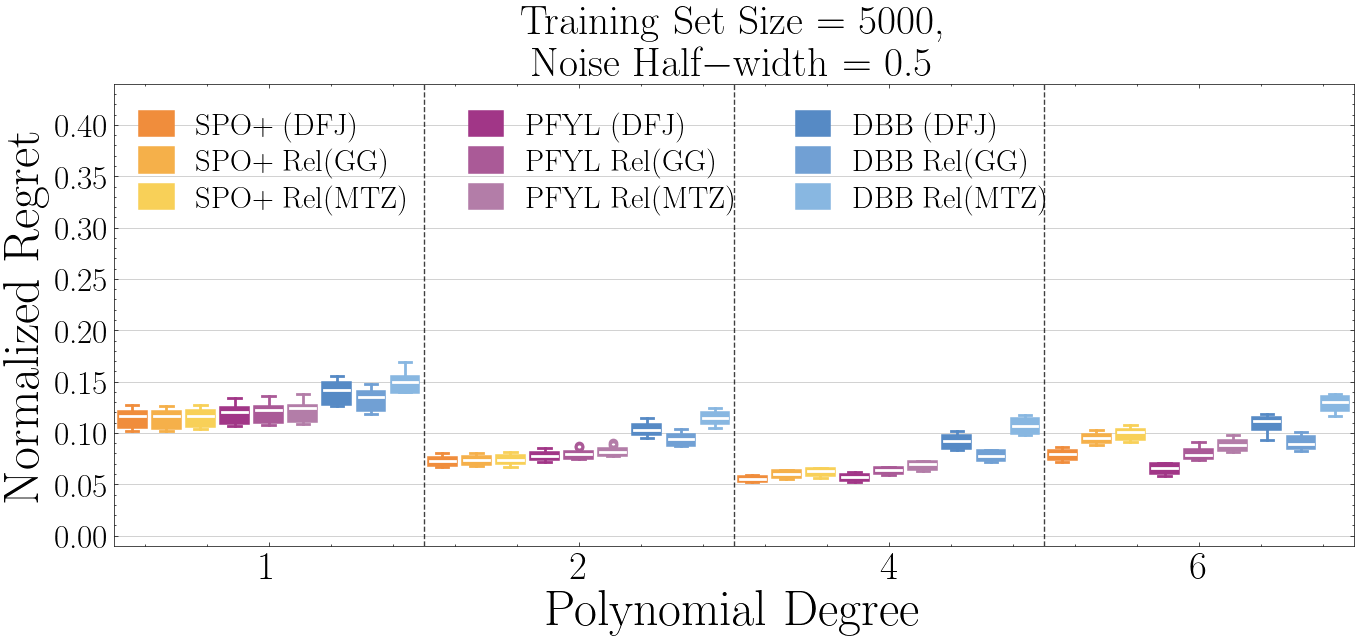

In [18]:
drawPlot(config, data=5000, noise=0.5)